https://github.com/nicolagheza/LogisticRegression/blob/master/LogisticRegression.py

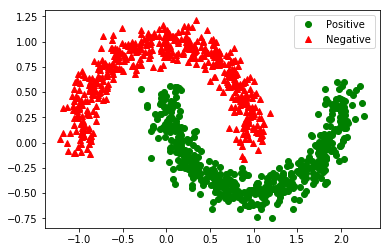

In [1]:
from datetime import datetime
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, recall_score

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

n_inputs = 2
m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

# Let's take a peek at the dataset
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label='Positive')
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label='Negative')
plt.legend()
plt.show()

Epoch: 0 	Loss: 0.7926023
Epoch: 500 	Loss: 0.2804781
Epoch: 1000 	Loss: 0.2745512
Epoch: 1500 	Loss: 0.2737534
Epoch: 2000 	Loss: 0.27340236
Epoch: 2500 	Loss: 0.2736211
Epoch: 3000 	Loss: 0.2740296
Epoch: 3500 	Loss: 0.27446824
Epoch: 4000 	Loss: 0.2745066
Epoch: 4500 	Loss: 0.27411395
Epoch: 5000 	Loss: 0.2746772
Epoch: 5500 	Loss: 0.27465606
Epoch: 6000 	Loss: 0.27525103
Epoch: 6500 	Loss: 0.2744236
Epoch: 7000 	Loss: 0.27471477
Epoch: 7500 	Loss: 0.27438414
Epoch: 8000 	Loss: 0.27453777
Epoch: 8500 	Loss: 0.27445695
Epoch: 9000 	Loss: 0.2741684
Epoch: 9500 	Loss: 0.27505225
Epoch: 10000 	Loss: 0.274644
precision_score 0.8584905660377359
recall_score 0.9191919191919192


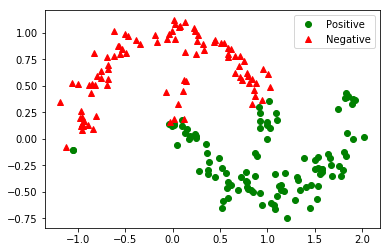

In [3]:
# We must not forget to add an extra bias feature (x0 = 1) to every instance.
X_moons_plus_bias = np.c_[np.ones((m,1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1, 1) # Reshape y_moons to make it a column vector

# Training set and test set split
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_plus_bias[:-test_size]
X_test = X_moons_plus_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

reset_graph()

def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_prob = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_prob, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_prob, loss, training_op, loss_summary, init, saver


# Next, let's create the graph, using the logistic_regression() function.
# We will also create the FileWriter to save the summaries to the log directory for Tensorboard:

n_inputs = 2 #+ 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_prob, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # If the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch:", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches): # Training
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    saver.save(sess, final_model_path)
    y_prob_val = y_prob.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)
    
y_pred = (y_prob_val >= 0.5)

print ('precision_score', precision_score(y_test, y_pred))
print ('recall_score', recall_score(y_test, y_pred))

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

W0726 19:35:24.458045 140598839146368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122366
Epoch: 1000 	Loss: 0.119032115
Epoch: 1500 	Loss: 0.09732921
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.07437582
Epoch: 3000 	Loss: 0.06750215
Epoch: 3500 	Loss: 0.062206887
Epoch: 4000 	Loss: 0.058026776
Epoch: 4500 	Loss: 0.05456297
Epoch: 5000 	Loss: 0.05170827
Epoch: 5500 	Loss: 0.049237728
Epoch: 6000 	Loss: 0.04716729
Epoch: 6500 	Loss: 0.045376647
Epoch: 7000 	Loss: 0.043818757
Epoch: 7500 	Loss: 0.04237423
Epoch: 8000 	Loss: 0.041089173
Epoch: 8500 	Loss: 0.039970923
Epoch: 9000 	Loss: 0.038920242
Epoch: 9500 	Loss: 0.03801075
Epoch: 10000 	Loss: 0.037155695
precision_score 0.9797979797979798
recall_score 0.9797979797979798


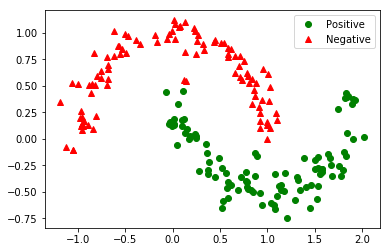

In [1]:
# We must not forget to add an extra bias feature (x0 = 1) to every instance.
X_moons_plus_bias = np.c_[np.ones((m,1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1, 1) # Reshape y_moons to make it a column vector

# Training set and test set split
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_plus_bias[:-test_size]
X_test = X_moons_plus_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

# add 4 more features to the inputs: x1^2, x2^2, x1^3 and x2^3.
# We will do this manually, look at sklearn.preprocessing.PolynomialFeatures
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:,1]),
                         np.square(X_train[:,2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                         np.square(X_test[:,1]),
                         np.square(X_test[:,2]),
                         X_test[:, 1] ** 3,
                         X_test[:, 2] ** 3]


reset_graph()

def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_prob = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_prob, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_prob, loss, training_op, loss_summary, init, saver


# Next, let's create the graph, using the logistic_regression() function.
# We will also create the FileWriter to save the summaries to the log directory for Tensorboard:

n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_prob, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # If the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch:", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches): # Training
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    saver.save(sess, final_model_path)
    y_prob_val = y_prob.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)
    
y_pred = (y_prob_val >= 0.5)

print ('precision_score', precision_score(y_test, y_pred))
print ('recall_score', recall_score(y_test, y_pred))

y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()